In [1]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

18.389524275269295 arcsec
11.62890385793019


/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


<Quantity 1.58136351 arcsec>

# Setup Interfaces

In [2]:
fsm = ImageStream('fsm')

In [3]:
fsm.write(v_bias)
# fsm.write(zero)

In [4]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [19]:
npsf = 100
cam.set_roi(570, 900, npsf, client0)

In [20]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 0.


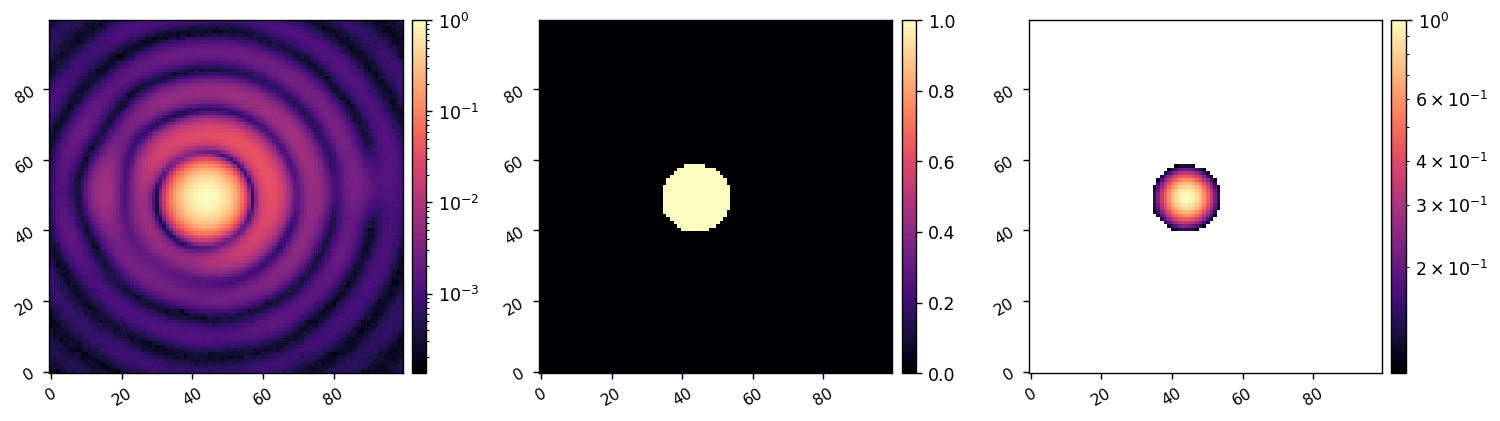

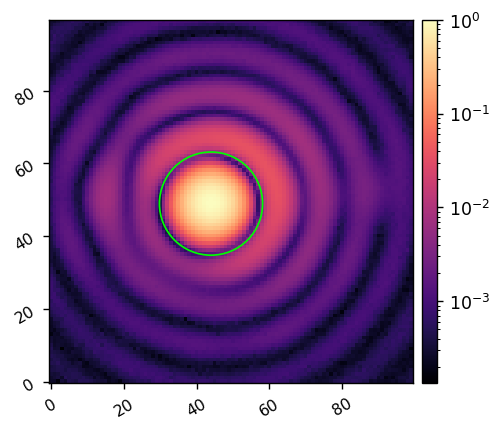

In [5]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.1, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


# Test the FSM modulation process

In [ ]:
freq = 15
amp = 0.25*as_per_lamD
amp = 350*u.mas / 2
t_total = 2

volt_commands = np.zeros((2, 3, 1))
volt_commands[0] = v_bias
# volt_commands[0] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=-amp)
volt_commands[1] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=amp)

print(volt_commands.T)

[[[50.         50.        ]
  [50.         50.05090544]
  [50.         49.94909456]]]


In [71]:
import multiprocessing

def modulate_fsm():
    print('Modulating FSM ...')
    i = 0
    while True:
        if i==2: i = 0
        fsm.write(volt_commands[i])
        time.sleep(1/freq)
        i += 1


In [12]:
mod = multiprocessing.Process(name='modulation', target=modulate_fsm, )

In [18]:
mod.start()

Modulating FSM ...


In [19]:
mod.terminate()


In [20]:
fsm.write(v_bias)

# Setup and record the modulation

In [98]:
freq = 50
amp = 0.25*as_per_lamD
amp = 350*u.mas / 2
t_total = 2

volt_commands = np.zeros((2, 3, 1))
volt_commands[0] = v_bias
# volt_commands[0] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=-amp)
volt_commands[1] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=amp)

print(volt_commands.T)

[[[50.         50.        ]
  [50.         50.05090544]
  [50.         49.94909456]]]


In [99]:
exp_time = client0[f'campupil.exptime.current']
fps = client0[f'campupil.fps.current']
data = {
    'EXPTIME':exp_time,
    'FPS':fps, 
    'T_TOTAL':t_total,
    'AMP':amp,
    'FREQ':freq,
}

cam.Nframes = t_total*fps
print(cam.Nframes)

mod = multiprocessing.Process(name='modulation', target=modulate_fsm, )
start_mod = time.time()
mod.start()
start_frames = time.time()
frames = cam.snap_cube()
mod.terminate()


2490.65991210938
Modulating FSM ...


In [123]:
# fsm.write(v_bias)
fsm.write(zero)

In [100]:
data.update({'IMAGES':frames})
data.update({'START':start_frames})
data.update({'START_MOD':start_mod})
utils.save_pickle(f'data/modulation/{today}_step_mod_{freq:.1f}.pkl', data)

Saved data to:  data/modulation/20241212_step_mod_50.0.pkl


# Analyze data

In [25]:
data.keys()

dict_keys(['EXPTIME', 'FPS', 'T_TOTAL', 'AMP', 'FREQ', 'IMAGES', 'START', 'START_MOD'])

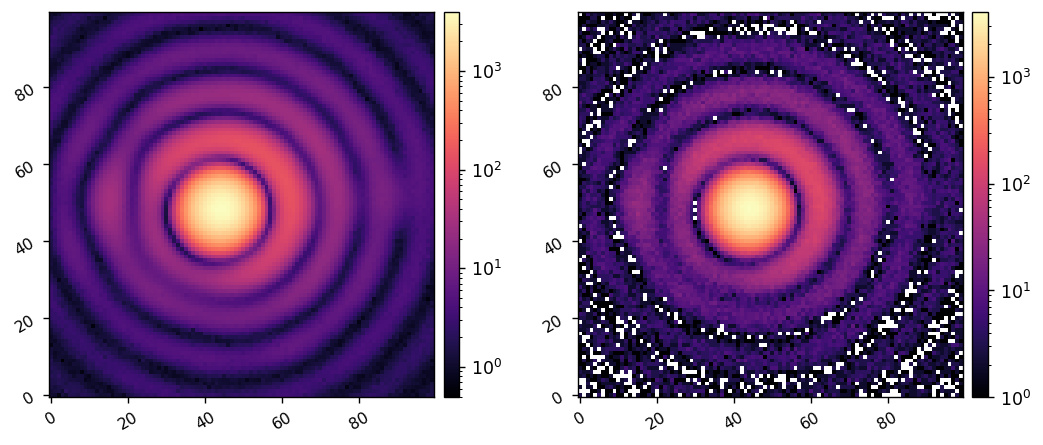

In [120]:
# data = utils.load_pickle(f'data/modulation/{20241210}_step_mod.pkl')
# data = utils.load_pickle(f'data/modulation/{20241210}_step_mod_3.pkl')

# data = utils.load_pickle(f'data/modulation/{20241212}_step_mod_10.0.pkl')
# data = utils.load_pickle(f'data/modulation/{20241212}_step_mod_15.0.pkl')
# data = utils.load_pickle(f'data/modulation/{20241212}_step_mod_20.0.pkl')
# data = utils.load_pickle(f'data/modulation/{20241212}_step_mod_25.0.pkl')
# data = utils.load_pickle(f'data/modulation/{20241212}_step_mod_30.0.pkl')
# data = utils.load_pickle(f'data/modulation/{20241212}_step_mod_35.0.pkl')
# data = utils.load_pickle(f'data/modulation/{20241212}_step_mod_40.0.pkl')
# data = utils.load_pickle(f'data/modulation/{20241212}_step_mod_45.0.pkl')
data = utils.load_pickle(f'data/modulation/{20241212}_step_mod_50.0.pkl')

ims = data['IMAGES']

N = ims.shape[0]
fps = data['FPS']
times = np.linspace(0, data['T_TOTAL'], N)

mean_frame = np.mean(ims, axis=0)
imshow2(mean_frame, ims[0], lognorm=True)

In [110]:
f'{data["FREQ"]}'

'10'

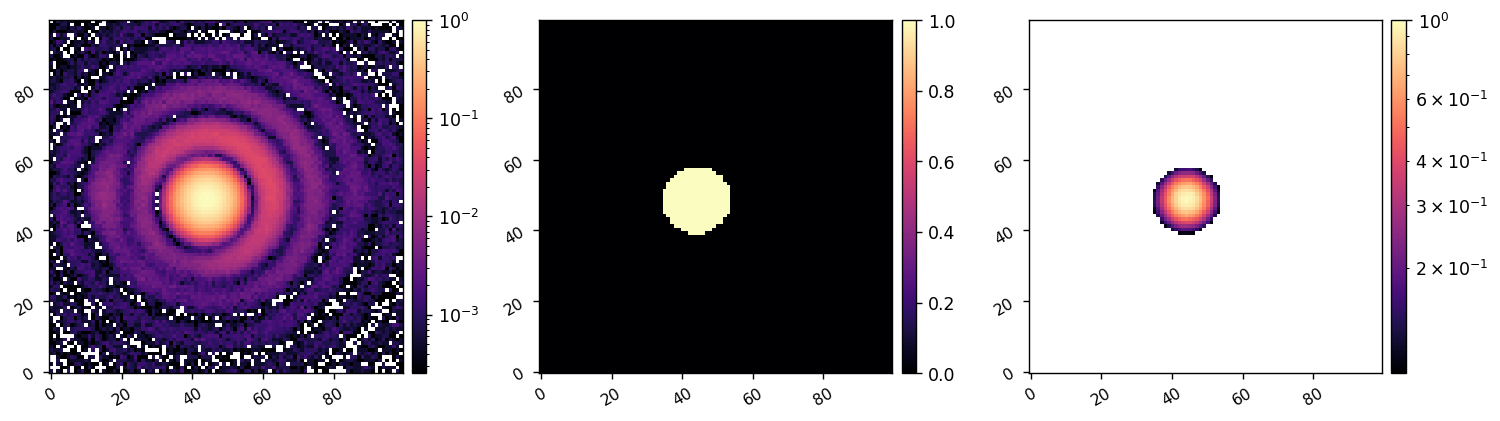

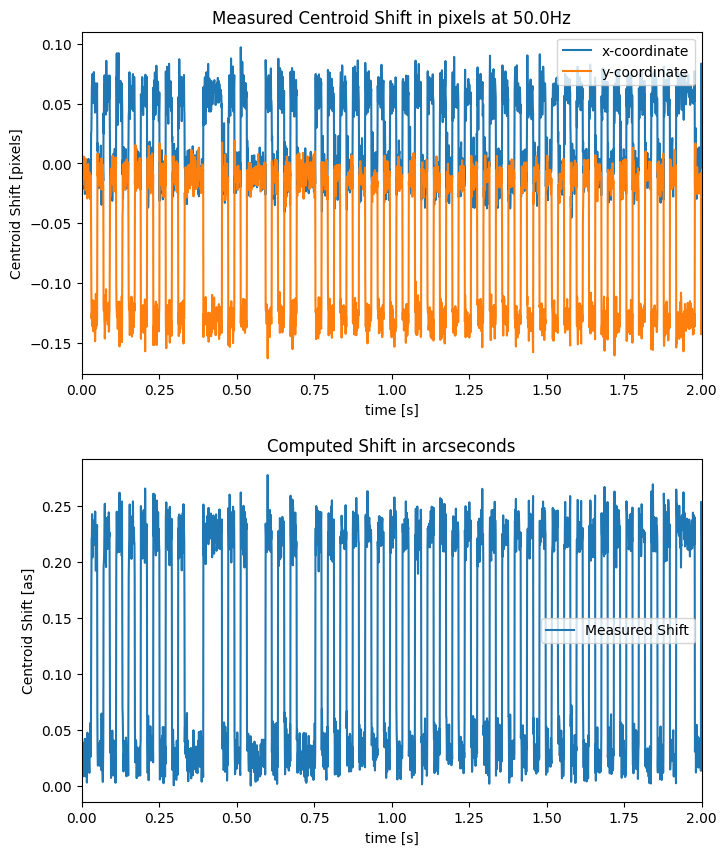

In [121]:
thresh = 0.1

shift_pix = []
cen_0 = utils.centroid(ims[0].astype(float), thresh=thresh, plot=True)
for i in range(N):
    cen = utils.centroid(ims[i].astype(float), thresh=thresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
shift_pix = np.array(shift_pix)

shift_pix[:,0] = shift_pix[:,0] - shift_pix[0,0]
shift_pix[:,1] = shift_pix[:,1] - shift_pix[0,1]

shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)
shift_as = np.sqrt( np.sum( np.square(shift_as), axis=1) )

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(times, shift_pix[:,0], label='x-coordinate')
plt.plot(times, shift_pix[:,1], label='y-coordinate')
plt.title(f'Measured Centroid Shift in pixels at {data["FREQ"]:.1f}Hz')
plt.ylabel('Centroid Shift [pixels]')
plt.xlabel('time [s]')
plt.xlim([0,times.max()])
plt.legend()

plt.subplot(212)
plt.plot(times, shift_as, label='Measured Shift')
# plt.axhline(y=data['AMP'].to_value(u.arcsec), color='r', linestyle='-', label='Input Amplitude')
# plt.xlim([0, 2])
plt.title('Computed Shift in arcseconds')
plt.ylabel('Centroid Shift [as]')
plt.xlabel('time [s]')
plt.xlim([0,times.max()])
plt.legend()

plt.subplots_adjust(hspace=0.25)
plt.show()